In [1]:
import pickle
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from requests import get
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
news = get('http://localhost:9200/slashnews/scraped/_search?sort=date:desc&size=5000').json()

In [3]:
df = pd.io.json.json_normalize(news['hits']['hits'])

In [4]:
df.head(1).T

,0
_id,c745f225-011c-5b49-bc91-87633a2e5ea7
_index,slashnews
_score,None
_source.body,By the time Donald J. Trump threw in the towel...
_source.categories,News
_source.date,2018-06-29T15:54:29.000Z
_source.language,English
_source.link,https://mondediplo.com/openpage/a-children-s-g...
_source.source,MondeDiplo
_source.subject,A children's Gitmo on the border


## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [5]:
df = df[['_source.body', '_source.subject', '_source.language', '_source.categories']]

In [6]:
df.head(1).T

,0
_source.body,By the time Donald J. Trump threw in the towel...
_source.subject,A children's Gitmo on the border
_source.language,English
_source.categories,News


In [7]:
df.columns = ['body', 'subject', 'language', 'categories']
df = df[pd.notnull(df['body'])]

In [8]:
#df.count()
df.drop_duplicates().count()

body          4992
subject       4992
language      4992
categories    4992
dtype: int64

In [9]:
def lst2str(x):
    if isinstance(x,(list, tuple)) or (',' in x):
        return ','.join(x)
    return x

In [10]:
# df['categories'] = df['categories'].apply(lst2str)

In [11]:
df.drop_duplicates(inplace=True)
df.head(1).T

,0
body,By the time Donald J. Trump threw in the towel...
subject,A children's Gitmo on the border
language,English
categories,News


In [12]:
df = df[df.categories != 'News']
df = df[df.categories != 'Turkey']
df = df[df.categories != 'BUSINESS']
df = df[df.categories != 'Uncategorized']

In [13]:
# df.groupby('categories')['categories'].count().value_counts(ascending=False)
# df.groupby('categories')['categories'].count().sort_values(ascending=False).drop_duplicates().head(15)
df.groupby(['categories']).agg({'count'}).drop_duplicates()

,body,subject,language
,count,count,count
categories,,,
"Accessories ,Games ,News",1,1,1
Arts & Life,79,79,79
Business,6,6,6
"Business ,Featured ,News",3,3,3
"Business ,Featured ,Opinion and Analysis",2,2,2
Economy,153,153,153
"Feature Articles ,Long War Journal ,Afghanistan",4,4,4
"Featured ,News ,Zimbabwe",5,5,5


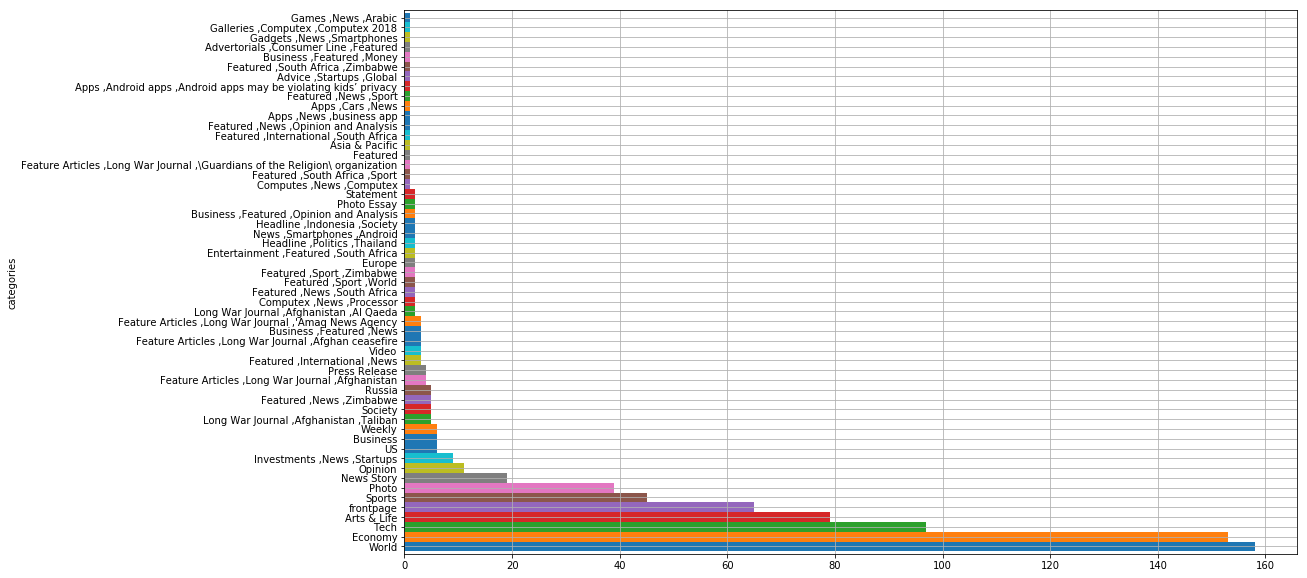

In [16]:
df.groupby('categories').body.count().sort_values(ascending=False).head(55).plot.barh(ylim=0, figsize=(16,10), width=1, grid=True)
plt.show()

In [17]:
df['cat_id'] = df['categories'].factorize()[0]

In [18]:
df.head(5)

,body,subject,language,categories,cat_id
2,Four most important stories on Russia this wee...,Russia calls the Putin-Trump summit the event ...,English,Weekly,0
14,Eritrea’s high level delegation composed of Mr...,Senior Eritrean delegation winds visit to Ethi...,English,frontpage,1
15,Newborn caretta carettas which hatched in the ...,Baby sea turtles crawl to sea in Turkey’s Muğla,English,Arts & Life,2
18,"An exhibition, which brings together Alev Ebüz...",Alev Ebüzziya’s ceramics at Baksı Museum,English,Arts & Life,2
19,A ball-shaped artificial intelligence robot ni...,'Flying brain' blasts off on cargo ship toward...,English,Arts & Life,2


In [19]:
cat_id_df = df[['categories', 'cat_id']].drop_duplicates().sort_values('cat_id')
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'categories']].values)

In [20]:
df.shape

(888, 5)

In [22]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.body).toarray()
labels = df.cat_id
print(len(features), len(labels), len(df.index))

(888, 888, 888)


In [23]:
# xtrain, xtest, ytrain, ytest, itrain, itest = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.2, random_state=42)

engines = [('LSVC', LinearSVC())]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(engines)))
for name, engine in engines:
    clf = make_pipeline(tfidf, engine)
    clf.fit(xtrain, ytrain)
    prediction = clf.predict(xtest)
    score = clf.score(xtest, prediction)
    
import pickle
with open('./pkl/lsvc.pickle', 'wb') as f:
    pickle.dump(clf, f)
    
print("{} \n{}".format(prediction, score))

[u'Long War Journal ,Danab ,Shabaab' u'World' u'Arts & Life' u'World'
 u'Economy' u'World' u'Tech' u'Arts & Life' u'Arts & Life'
 u'News ,Smartphones ,Adreno' u'World' u'Economy' u'Economy' u'Economy'
 u'World' u'Sports' u'Tech' u'Economy' u'World' u'Tech'
 u'Ecosystem ,Startups ,Beirut' u'Photo' u'Sports' u'Tech'
 u'Long War Journal ,Afghanistan ,Taliban' u'Photo' u'frontpage' u'World'
 u'Tech' u'Economy' u'Arts & Life' u'Tech' u'World' u'Economy' u'Tech'
 u'Economy' u'Entertainment ,Featured ,South Africa' u'Tech' u'World'
 u'World' u'Economy' u'Economy' u'Headline ,Politics ,Thailand' u'World'
 u'Arts & Life' u'Economy' u'Tech' u'World'
 u'News ,Smartphones ,Coral Blue' u'Weekly' u'World' u'World' u'World'
 u'Tech' u'Computes ,Galleries ,Computex' u'frontpage' u'News Story'
 u'Economy' u'World' u'frontpage' u'frontpage' u'World' u'World' u'Tech'
 u'Economy' u'Business ,Featured ,News' u'Photo' u'Economy' u'Economy'
 u'eSports ,News ,BenQ' u'frontpage' u'Tech' u'World' u'Arts & Life'

In [24]:
s = '''

‘Guys, you’ve got to hear this,” I said. I was sitting in front of my computer one day in July 2012, with one eye on a screen of share prices and the other on a live stream of the House of Commons Treasury select committee hearings. As the Barclays share price took a graceful swan dive, I pulled my headphones out of the socket and turned up the volume so everyone could hear. My colleagues left their terminals and came around to watch BBC Parliament with me.

It didn’t take long to realise what was happening. “Bob’s getting murdered,” someone said.

Bob Diamond, the swashbuckling chief executive of Barclays, had been called before the committee to explain exactly what his bank had been playing at in regards to the Libor rate-fixing scandal. The day before his appearance, he had made things very much worse by seeming to accuse the deputy governor of the Bank of England of ordering him to fiddle an important benchmark, then walking back the accusation as soon as it was challenged. He was trying to turn on his legendary charm in front of a committee of angry MPs, and it wasn’t working. On our trading floor, in Mayfair, calls were coming in from all over the City. Investors needed to know what was happening and whether the damage was reparable.

A couple of weeks later, the damage was done. The money was gone, Diamond was out of a job and the market, as it always does, had moved on. We were left asking ourselves: How did we get it so wrong?

'''

In [25]:
say = clf.predict([s])
score = clf.score([s], say)
print(say[0], score)

(u'Economy', 1.0)
